# Predictions statistics

Analysis of the predictions made for a certain datasplit (usually test).

**Note:** To run this notebook you previously have to run and save the predictions on a test dataset **with ground-truth values**. See the Datasplit section in [3.0 notebook](./3.0-Computing_predictions.ipynb#Predicting-a-datasplit-txt-file) for reference.


In [73]:
import os
import json
import numpy as np

from imgclas.data_utils import load_image
from imgclas import paths, plot_utils
from imgclas import test_utils
import sklearn.metrics as metrics
import math
import statistics
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [68]:
def get_bin(true_values):
    
    grams = [100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375]
    bins = [87.5, 112.5, 137.5, 162.5, 187.5, 212.5, 237.5, 262.5, 287.5, 312.5, 337.5, 362.5, 387.5]
    
    
    if type(true_values) == list:
        result = list()
        for e in true_values:
            l = len(bins)
            index = 0
            for i in range(l):
                try:
                    if bins[i] < float(e) and bins[i+1] > float(e):
                        index = i
                        result.append(grams[index])
                        break
                except:
                    print("Error:", e)
    else:
        l = len(bins)
        index = 0
        for i in range(l):
            try:
                if bins[i] < float(true_values) and bins[i+1] > float(true_values):
                    index = i
                    result = grams[index]
                    break
            except:
                print("Error:", true_values)
        
    
    return result

In [145]:
def get_sample_predictions(timestamp=None, bootstrapping_predictions_folder=None, sample_name='bootstrapping_sample-', num_sample=0, bin_size=None):
    
    if timestamp == None or bootstrapping_predictions_folder == None:
        raise Exception("timestamp and bootstrapping_predictions_folder parameters needed") 
    
    # Set the timestamp
    paths.timestamp = timestamp

    # Load back the predictions
    pred_path = os.path.join(paths.get_predictions_dir(), '{}/{}{}.json'.format(bootstrapping_predictions_folder, sample_name, num_sample))
    with open(pred_path) as f:
        pred_dict = json.load(f)

    y, y_pred = np.array(pred_dict['true_value']), np.array(pred_dict['pred_value'])
    
    
    if bin_size != None:
        aux_y=[]
        aux_y_pred=[] 
        for (t,p) in zip(y,y_pred):
            if get_bin(t) == bin_size:
                aux_y.append(t)
                aux_y_pred.append(p)
        y = aux_y
        y_pred = aux_y_pred

    return y, y_pred

In [154]:
def compute_error(y, y_pred):
    mae = metrics.mean_absolute_error(y, y_pred)
    
    # Calcular el error residual para el intervalo de confianza 
    errores_absolutos = np.abs(np.array(y) - np.array(y_pred))
    
    # Calcular errores relativos
    errores_relativos = errores_absolutos / y

    
    '''
    #Calculo el error maximo por encima y por debajo
    max_positive_error = -math.inf
    max_negative_error = math.inf
    for (t,p) in zip(y,y_pred):
        error = p-t
        if error > max_positive_error:
            max_positive_error = error
        if error < max_negative_error:
            max_negative_error = error
    '''
        
    return mae, list(errores_absolutos), errores_relativos
    

In [155]:
def bootstrapping_statistics(timestamp=None, bootstrapping_predictions_folder=None, sample_name='bootstrapping-epoch-20', num_samples=1, bin_size=None, conf=0.95):
    
    samples_mae = []
    samples_errores_absolutos = []
    samples_errores_relativos = []
    for i in range(0,num_samples):
        y, y_pred = get_sample_predictions(timestamp, bootstrapping_predictions_folder, sample_name, num_sample=i, bin_size=bin_size)
        mae, error_absoluto, error_relativo = compute_error(y, y_pred)
        
        samples_mae.append(mae)
        samples_errores_absolutos.extend(error_absoluto)
        samples_errores_relativos.extend(error_relativo)
    
    mae = statistics.mean(samples_mae)
    confidence_interval = stats.t.interval(conf, len(samples_errores_absolutos)-1, loc=np.mean(samples_errores_absolutos), scale=stats.sem(samples_errores_absolutos))
    error_relativo_promedio = np.mean(samples_errores_relativos)
    
    return mae, confidence_interval, error_relativo_promedio

# General bootstrapping statistics

In [156]:
mae, confidence_interval, error_relativo_promedio = bootstrapping_statistics(timestamp='2024-02-01_115602', 
                                                   bootstrapping_predictions_folder='bootstrapping-epoch-20',
                                                   sample_name='bootstrapping_sample-', num_samples=100, conf=0.95)
print("MAE: ",mae, "±", error_relativo_promedio)
print("95% Intervalo de confianza: ", confidence_interval)

MAE:  27.379299965667723 ± 0.11723253231577248
95% Intervalo de confianza:  (27.239995776957734, 27.518604154377712)


# Bootstrapping statistics by size


In [ ]:
mae, confidence_interval, error_relativo_promedio = bootstrapping_statistics(timestamp='2024-02-01_115602', 
                                                                       bootstrapping_predictions_folder='bootstrapping-epoch-20', 
                                                                       sample_name='bootstrapping_sample-', num_samples=100, bin_size=300)
print("MAE: ",mae, "±", error_relativo_promedio)
print("95% Intervalo de confianza: ", confidence_interval)

MAE:  32.92972037204905 ± 0.10738067698855919
95% Intervalo de confianza:  (32.52544275572967, 33.33542455219164)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

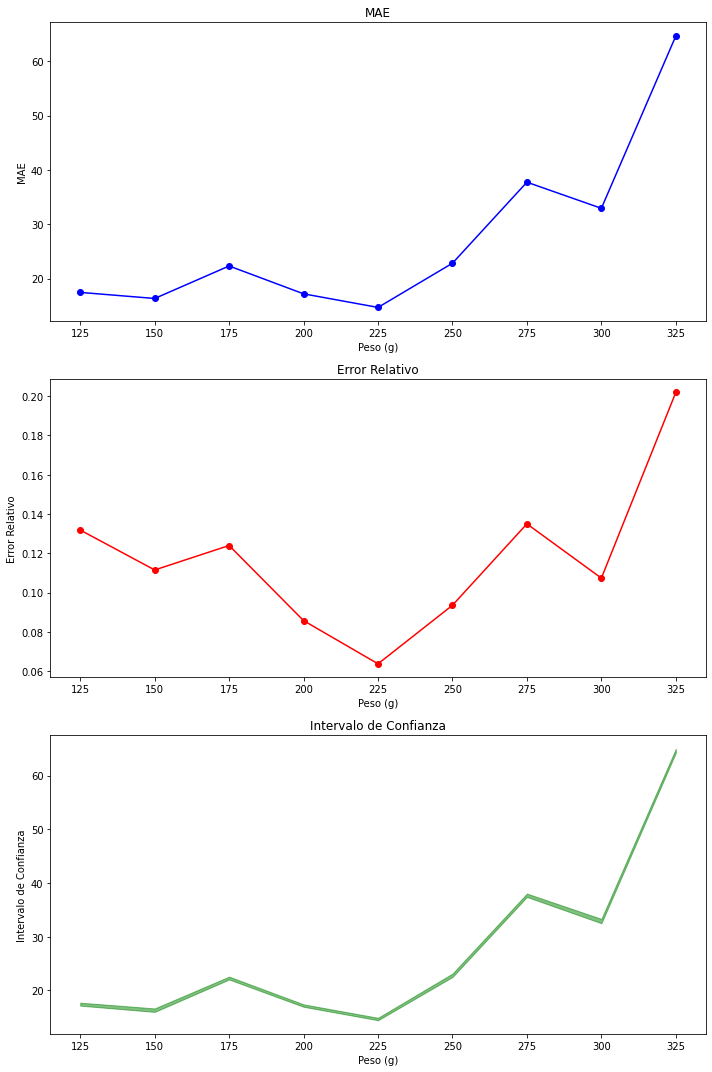

In [170]:
sizes = [125, 150, 175, 200, 225, 250 ,275, 300, 325]


mae_by_size=[]
errorRelativo_by_size=[]
ic_by_size=[]
for s in sizes:
    mean_absolute_error, confidence_interval, error_relativo_promedio = bootstrapping_statistics(timestamp='2024-02-01_115602', 
                                                                           bootstrapping_predictions_folder='bootstrapping-epoch-20', 
                                                                           sample_name='bootstrapping_sample-', num_samples=100, bin_size=s)
    mae_by_size.append(mean_absolute_error)
    errorRelativo_by_size.append(error_relativo_promedio)
    ic_by_size.append(confidence_interval)
    
    
# Crear subgráficos
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Gráfico de MAE
axs[0].plot(sizes, mae_by_size, marker='o', color='b')
axs[0].set_title('MAE')
axs[0].set_xlabel('Peso (g)')
axs[0].set_ylabel('MAE')

# Gráfico de error relativo
axs[1].plot(sizes, errorRelativo_by_size, marker='o', color='r')
axs[1].set_title('Error Relativo')
axs[1].set_xlabel('Peso (g)')
axs[1].set_ylabel('Error Relativo')

# Gráfico de intervalo de confianza
intervalo_confianza_min = [ic[0] for ic in ic_by_size]
intervalo_confianza_max = [ic[1] for ic in ic_by_size]
axs[2].fill_between(sizes, intervalo_confianza_min, intervalo_confianza_max, color='g', alpha=0.5)
axs[2].set_title('Intervalo de Confianza')
axs[2].set_xlabel('Peso (g)')
axs[2].set_ylabel('Intervalo de Confianza')

# Ajustar espaciado
plt.tight_layout()

# Mostrar gráfico
plt.show()

# Real Test statistics

In [159]:
# User parameters to set
TIMESTAMP = '2024-02-01_115602'       # timestamp of the model              
SPLIT_NAME = 'test'                   # dataset split to predict
MODEL_NAME = 'epoch-20.hdf5'         # model to use to make the mediction

# Set the timestamp
paths.timestamp = TIMESTAMP

# Load back the predictions
pred_path = os.path.join(paths.get_predictions_dir(), '{}+{}.json'.format(MODEL_NAME, SPLIT_NAME))
with open(pred_path) as f:
    pred_dict = json.load(f)
    
y, y_pred = np.array(pred_dict['true_value']), np.array(pred_dict['pred_value'])
    
mae, errores_absolutos, errores_relativos = compute_error(y, y_pred)

confidence_interval = stats.t.interval(0.95, len(errores_absolutos)-1, loc=np.mean(errores_absolutos), scale=stats.sem(errores_absolutos))
error_relativo_promedio = np.mean(errores_relativos)
    
print("MAE: ",mae, "±", error_relativo_promedio)
print("95% Intervalo de confianza: ", confidence_interval)

MAE:  21.837328576329927 ± 0.1048374968606077
95% Intervalo de confianza:  (21.054642617853897, 22.620014534805957)
